## Today I'll work on classifying genders by their voice using classical ML and some data analysis and visualizations

### Importing libraries 

In [53]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
#preprocess.
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/voicegender/voice.csv


### Reading our dataset.

In [54]:
df_train= pd.read_csv('/kaggle/input/voicegender/voice.csv')
df_train.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [55]:
df_train.shape

(3168, 21)

In [56]:
df_train.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')

### from data description we know that :

meanfreq: mean frequency (in kHz)

sd: standard deviation of frequency

median: median frequency (in kHz)

Q25: first quantile (in kHz)

Q75: third quantile (in kHz)

IQR: interquantile range (in kHz)

skew: skewness (see note in specprop description)

kurt: kurtosis (see note in specprop description)

sp.ent: spectral entropy

sfm: spectral flatness

mode: mode frequency

centroid: frequency centroid (see specprop)

peakf: peak frequency (frequency with highest energy)

meanfun: average of fundamental frequency measured across acoustic signal

minfun: minimum fundamental frequency measured across acoustic signal

maxfun: maximum fundamental frequency measured across acoustic signal

meandom: average of dominant frequency measured across acoustic signal

mindom: minimum of dominant frequency measured across acoustic signal

maxdom: maximum of dominant frequency measured across acoustic signal

dfrange: range of dominant frequency measured across acoustic signal

modindx: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of fundamental frequencies divided by the frequency range

label: male or female

### let's check missing values

In [57]:
df_train.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

### no missing values

### performing EDA with plots.

In [58]:
df_train.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.895127,0.408216,0.165282,0.180907,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.044980,0.177521,0.077203,0.029918,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.738651,0.036876,0.000000,0.039363,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.861811,0.258041,0.118016,0.163662,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.901767,0.396335,0.186599,0.184838,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.928713,0.533676,0.221104,0.199146,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.981997,0.842936,0.280000,0.251124,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374


### let's check if we have outliers in our data by calculating the 1.5 IQR range

In [59]:
def check_outliers(col):
    q1,q3=df[col].quantile([0.25,0.75])
    iqr=q3-q1
    rang=1.5*iqr
    return(q1-rang,q3+rang)

## Univariate analysis

### since all features are numeric, I'll use histogram and box plot 

In [60]:
def plot(col):
    fig,axes=plt.subplots(1,2)
    sns.boxplot(data=df,x=col,ax=axes[0])
    sns.distplot(a=df[col],ax=axes[1],color='#ff4125')
    fig.set_size_inches(15,5)
    lower,upper = check_outliers(col)
    l=[df[col] for i in df[col] if i>lower and i<upper] 
    print("Number of data points remaining if outliers removed : ",len(l))

In [61]:
df=df_train

In [62]:
del df_train

In [63]:
df.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')

Number of data points remaining if outliers removed :  3104


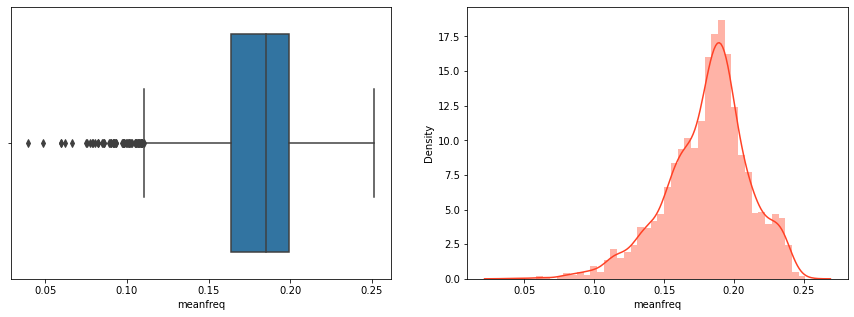

In [64]:
plot('meanfreq')

1. from box plot: we have some outliers according to 1.5 IQR rule
2. from distplot: the distribution is not perfect;y normal, we have very little -ve skewness >> we can normalize that.
3. more outliers are on the left of the distribution.

Number of data points remaining if outliers removed :  3158


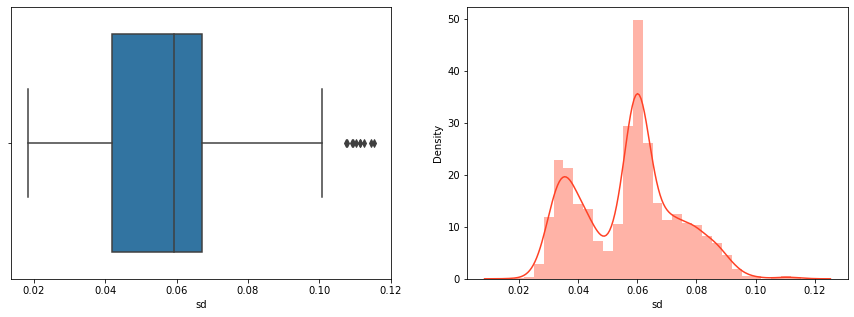

In [65]:
plot('sd')

Number of data points remaining if outliers removed :  3059


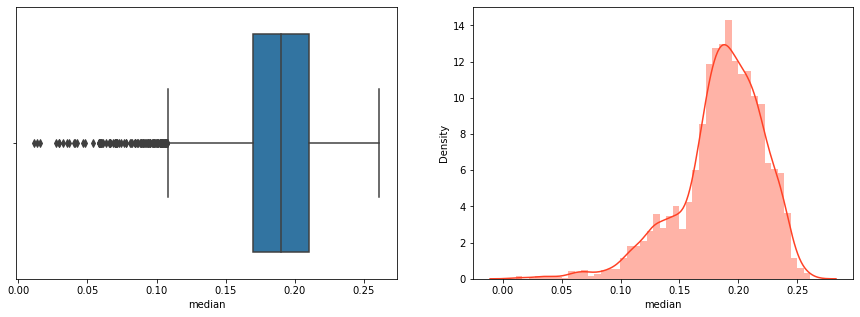

In [66]:
plot('median')

Number of data points remaining if outliers removed :  3135


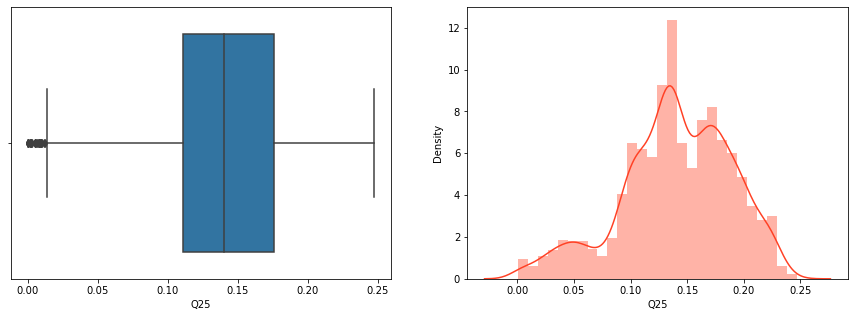

In [67]:
plot('Q25')

Number of data points remaining if outliers removed :  3141


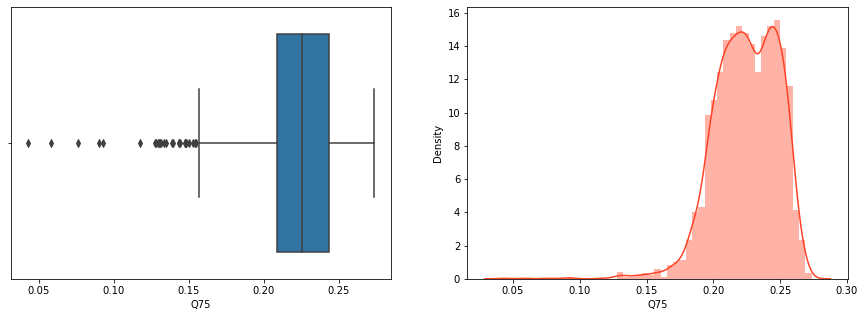

In [68]:
plot('Q75')

Number of data points remaining if outliers removed :  2938


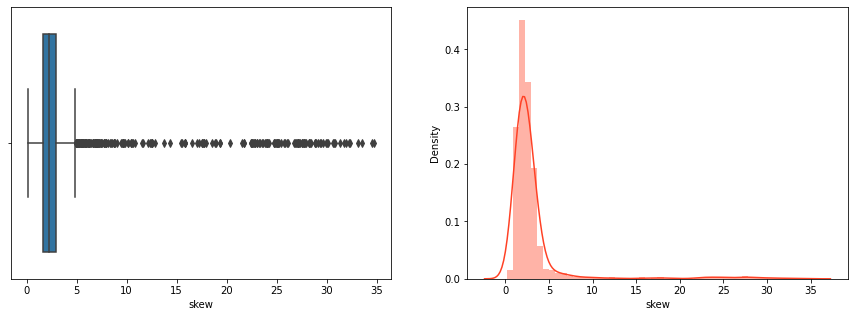

In [69]:
plot('skew')

Number of data points remaining if outliers removed :  2836


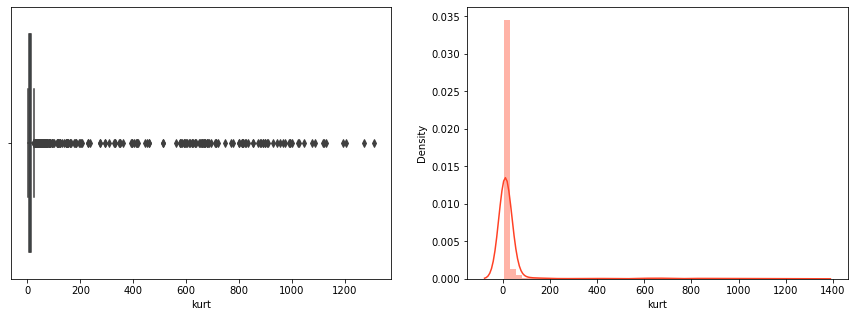

In [70]:
plot('kurt')

Number of data points remaining if outliers removed :  3162


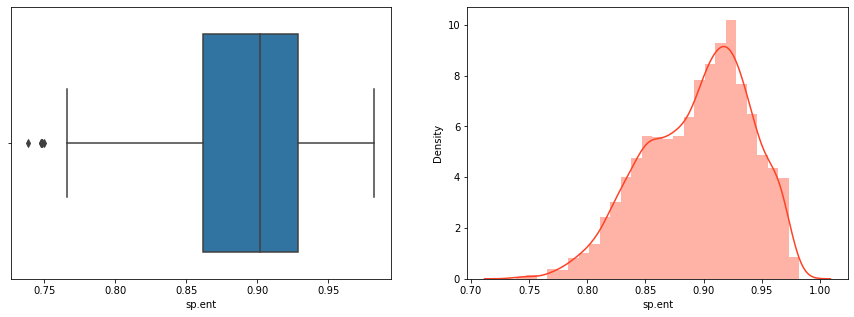

In [71]:
plot('sp.ent')

Number of data points remaining if outliers removed :  3168


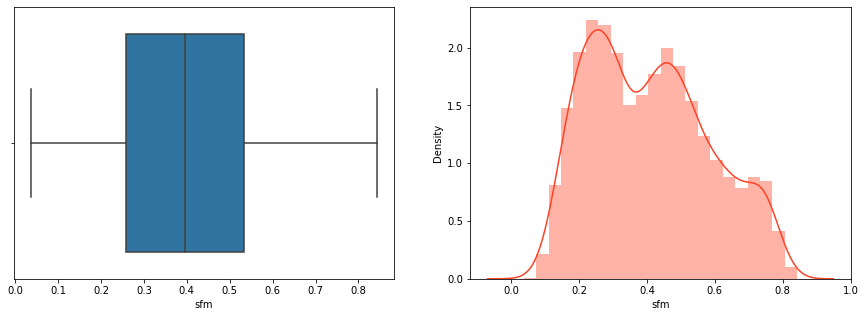

In [72]:
plot('sfm')

Number of data points remaining if outliers removed :  3168


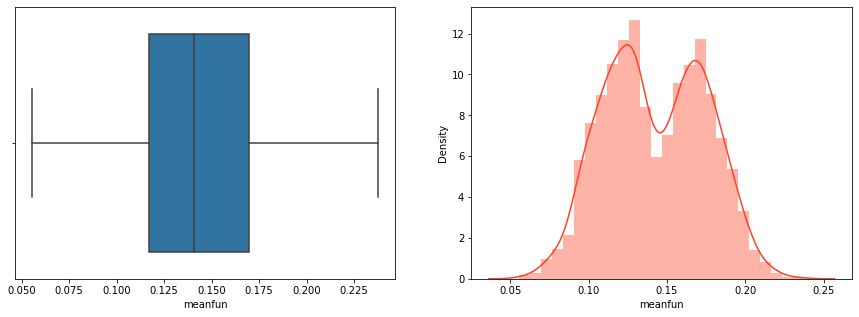

In [73]:
plot('meanfun')

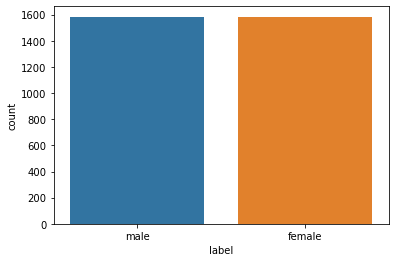

In [74]:
sns.countplot(data=df,x='label');

### luckily our data is balanced "equal number of classes"

##  Bivariate Analysis

1. Correlation between data features

### make class labels 0,1 instead of male, female

In [75]:
df['label']=df['label'].replace({'male':1,'female':0})

In [76]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1


<AxesSubplot:>

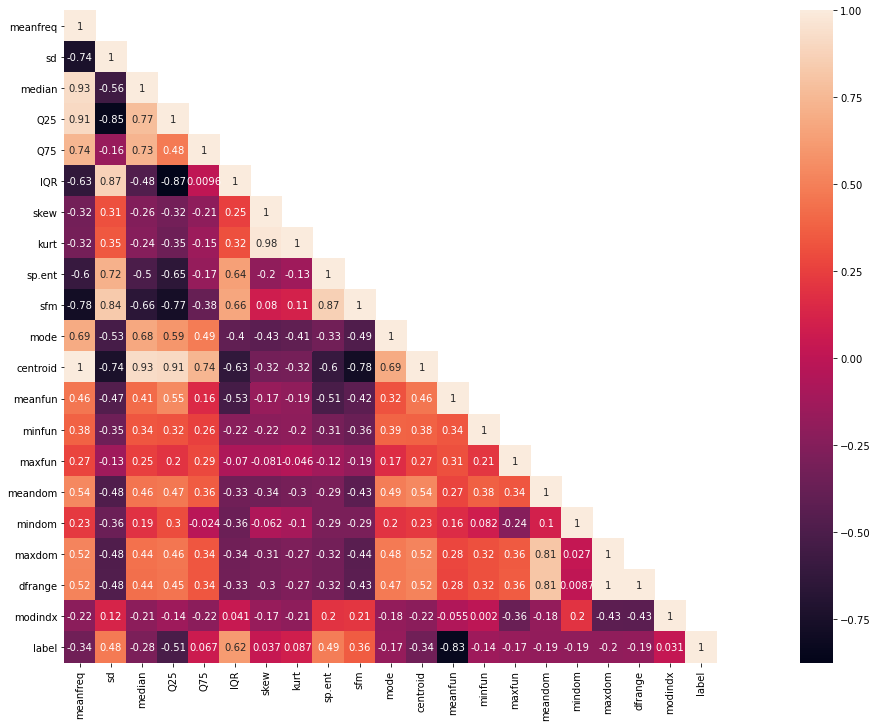

In [77]:
# correlation heatmap 
cor_mat= df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

1. IQR is the most correlated feature with the target label
2. median and centroid () , mean freq and centroid >> delete centroid
3. other obseravtions, there are weak correlations and high ones, i'll delete some columns in feature engineering.

### plot features against target label to compare distributions.

In [78]:
def plot_against_target(feature):
    sns.factorplot(data=df,y=feature,x='label',kind='box')
    fig=plt.gcf()
    fig.set_size_inches(7,7)

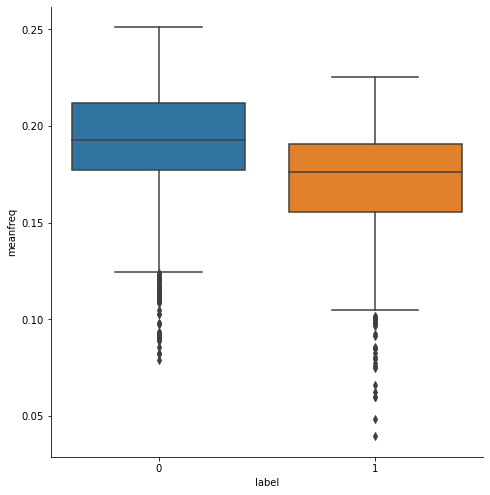

In [79]:
plot_against_target('meanfreq')

### females have higher mean frequency than males.

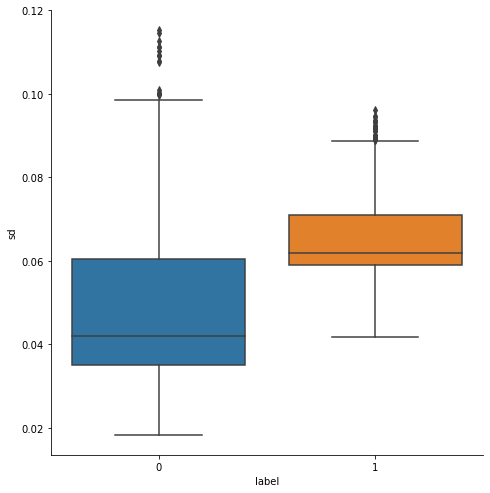

In [80]:
plot_against_target('sd')

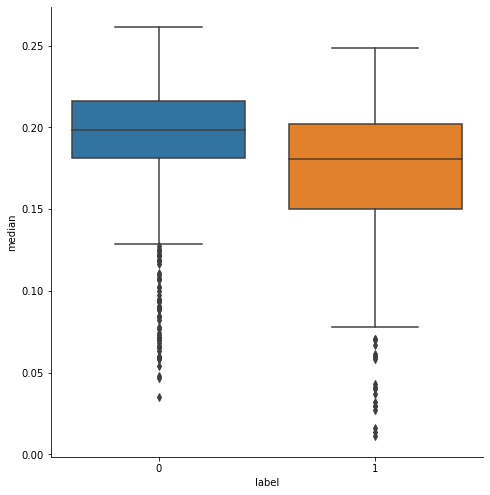

In [81]:
plot_against_target('median')

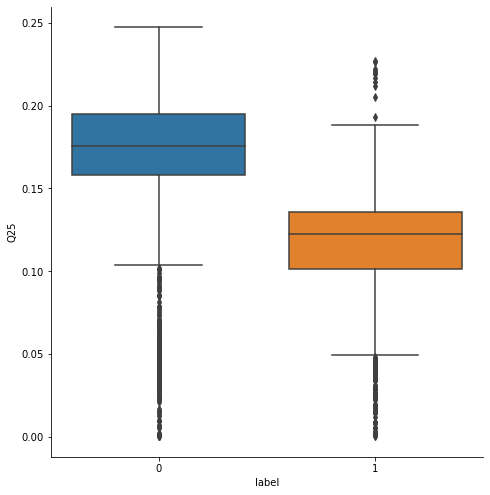

In [82]:
plot_against_target('Q25')

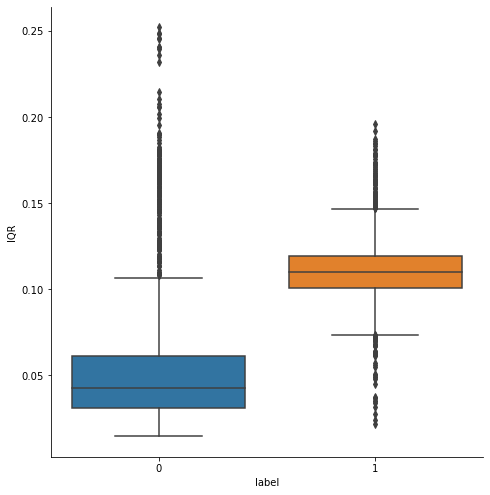

In [83]:
plot_against_target('IQR')

we know the strong relation between the target label and IQR and this is 

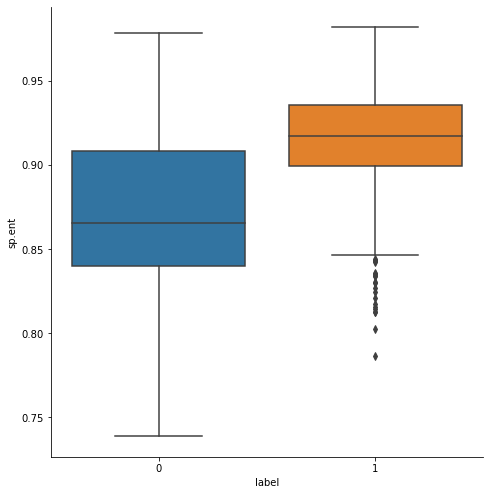

In [84]:
plot_against_target('sp.ent')

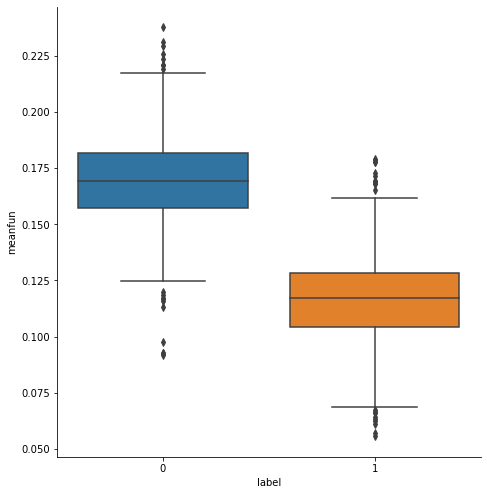

In [85]:
plot_against_target('meanfun')  

### let's plot a pairplot grid with scatter plots to compare features

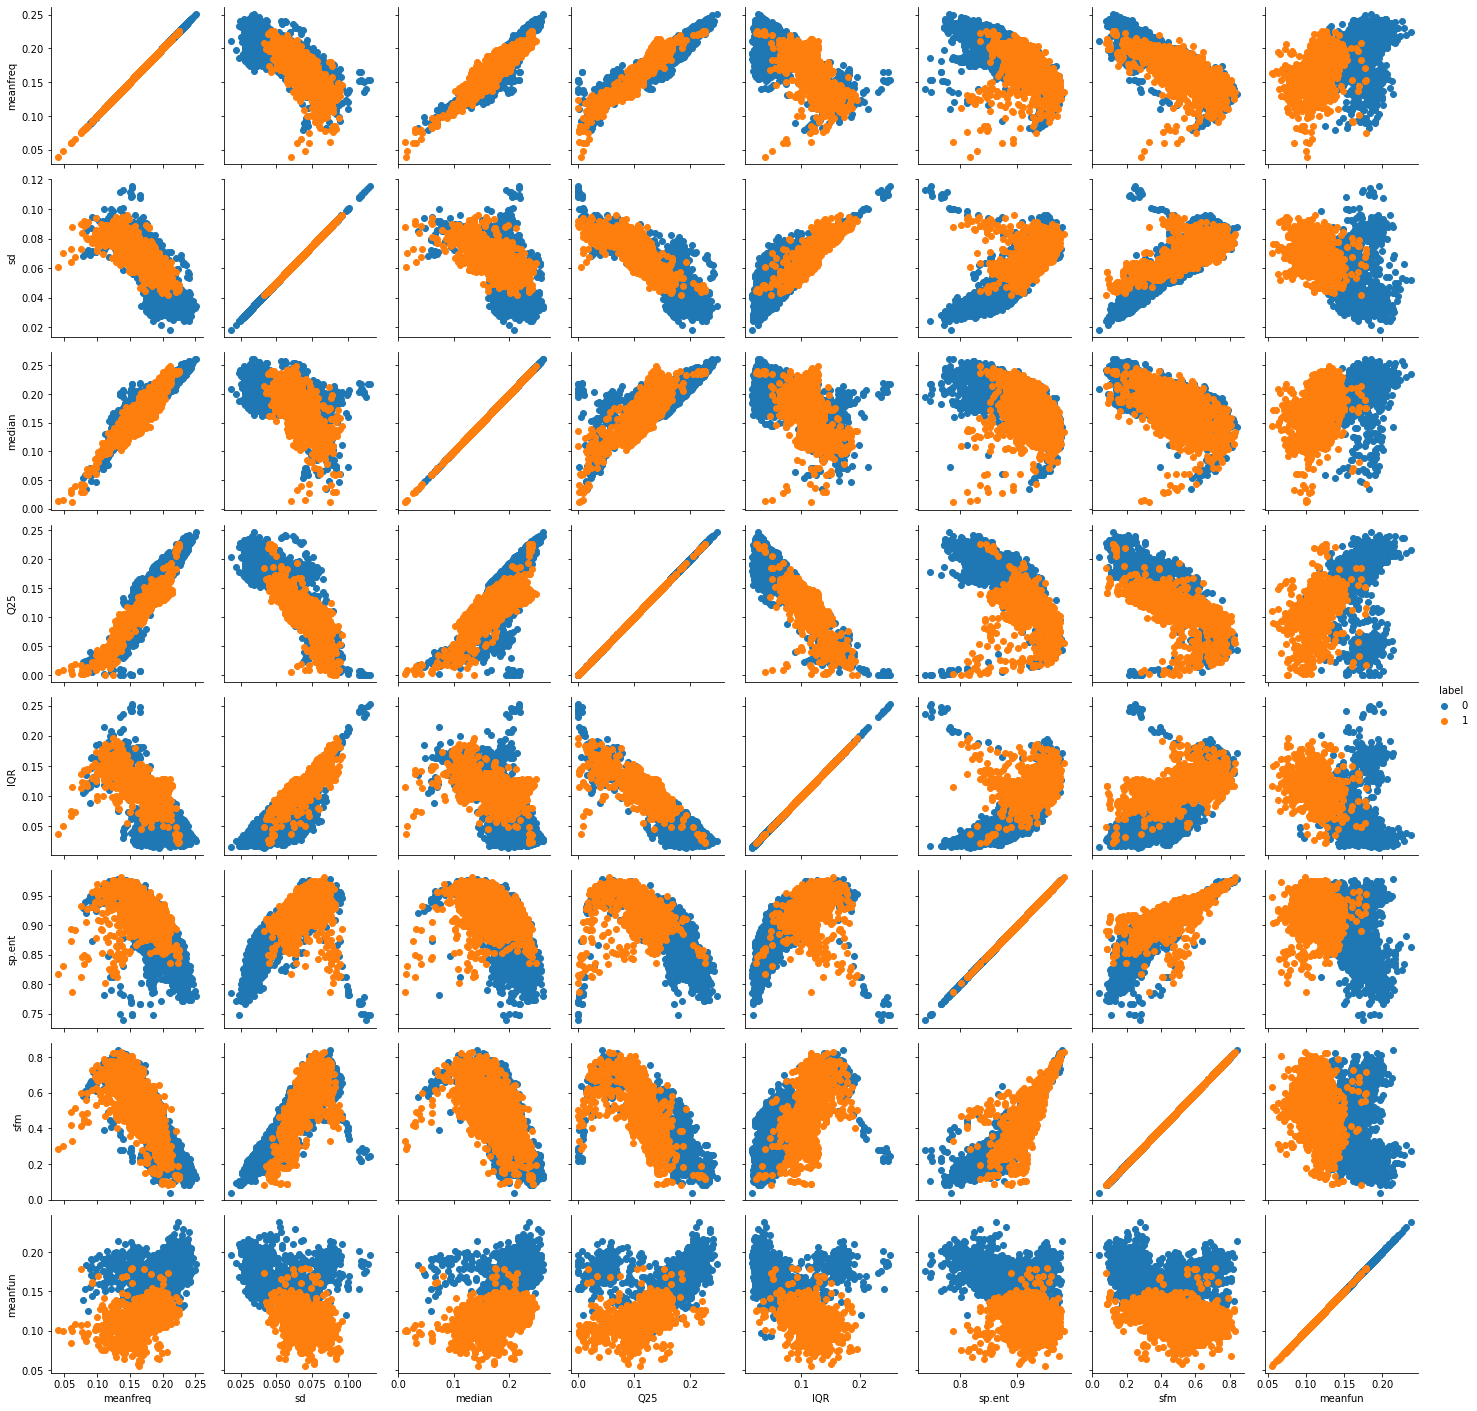

In [86]:
g = sns.PairGrid(df[['meanfreq','sd','median','Q25','IQR','sp.ent','sfm','meanfun','label']], hue = "label")
g = g.map(plt.scatter).add_legend()

I'll comment on this section in the feature engineering

### let's remove the outliers

In [87]:
for col in df.columns:
    l,u=check_outliers(col)
    df=df[(df[col]>l)&(df[col]<u)]

In [88]:
df.shape

(1607, 21)

### so the number of observations reduced when we deleted the outliers.

## Feature engineering, My fav part. ^^

so according to previous plots, we'll delete "skew,kurt,mindom,maxdom,centroid"

In [89]:
temp_df=df.copy()
temp_df.drop(['skew','kurt','mindom','maxdom','centroid'],axis=1,inplace=True)

In [90]:
temp_df.head()

,meanfreq,sd,median,Q25,Q75,IQR,sp.ent,sfm,mode,meanfun,minfun,maxfun,meandom,dfrange,modindx,label
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,0.963322,0.727232,0.083878,0.088965,0.017798,0.250000,0.201497,0.554688,0.247119,1
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,0.971955,0.783568,0.104261,0.106398,0.016931,0.266667,0.712812,5.476562,0.208274,1
5,0.132786,0.079557,0.119090,0.067958,0.209592,0.141634,0.963181,0.738307,0.112555,0.110132,0.017112,0.253968,0.298222,2.718750,0.125160,1
6,0.150762,0.074463,0.160106,0.092899,0.205718,0.112819,0.967573,0.762638,0.086197,0.105945,0.026230,0.266667,0.479620,5.304688,0.123992,1
8,0.142239,0.078018,0.138587,0.088206,0.208587,0.120381,0.970723,0.770992,0.219103,0.096729,0.017957,0.250000,0.336476,2.156250,0.148272,1


### creating new features

In [91]:
## skewness with pearson coefficient
temp_df['pear_skew']=temp_df['meanfreq']-temp_df['mode']
temp_df['pear_skew']=temp_df['pear_skew']/temp_df['sd']
temp_df.head(10)

,meanfreq,sd,median,Q25,Q75,IQR,sp.ent,sfm,mode,meanfun,minfun,maxfun,meandom,dfrange,modindx,label,pear_skew
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,0.963322,0.727232,0.083878,0.088965,0.017798,0.250000,0.201497,0.554688,0.247119,1,0.933981
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,0.971955,0.783568,0.104261,0.106398,0.016931,0.266667,0.712812,5.476562,0.208274,1,0.389899
5,0.132786,0.079557,0.119090,0.067958,0.209592,0.141634,0.963181,0.738307,0.112555,0.110132,0.017112,0.253968,0.298222,2.718750,0.125160,1,0.254296
6,0.150762,0.074463,0.160106,0.092899,0.205718,0.112819,0.967573,0.762638,0.086197,0.105945,0.026230,0.266667,0.479620,5.304688,0.123992,1,0.867080
8,0.142239,0.078018,0.138587,0.088206,0.208587,0.120381,0.970723,0.770992,0.219103,0.096729,0.017957,0.250000,0.336476,2.156250,0.148272,1,-0.985199
16,0.190846,0.065790,0.207951,0.132280,0.244357,0.112076,0.938546,0.538810,0.050129,0.113323,0.017544,0.275862,1.434115,6.312500,0.254780,1,2.138871
18,0.168346,0.074121,0.145618,0.115756,0.239824,0.124068,0.934523,0.559742,0.060033,0.083484,0.015717,0.231884,0.146563,3.117188,0.059537,1,1.461303
21,0.181015,0.074369,0.169299,0.128673,0.254175,0.125502,0.915284,0.475317,0.059957,0.098643,0.016145,0.275862,0.209844,3.687500,0.059940,1,1.627803
32,0.175659,0.071652,0.144192,0.131058,0.256527,0.125469,0.876749,0.403910,0.134411,0.132726,0.016563,0.228571,0.257812,0.640625,0.203437,1,0.575679
33,0.174826,0.071533,0.146471,0.123529,0.247059,0.123529,0.875392,0.436706,0.120000,0.124685,0.016754,0.250000,0.799006,4.164062,0.205816,1,0.766442


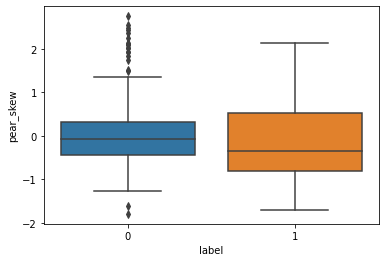

In [92]:
sns.boxplot(data=temp_df,y='pear_skew',x='label');

change median column to be 1/3(2mean+mode)

In [93]:
temp_df['meanfreq']=temp_df['meanfreq'].apply(lambda x:x*2)
temp_df['median']=temp_df['meanfreq']+temp_df['mode']
temp_df['median']=temp_df['median'].apply(lambda x:x/3)

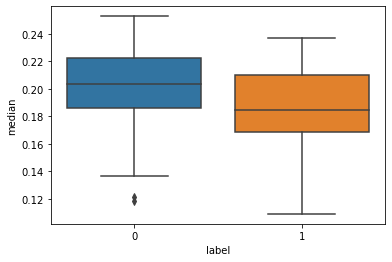

In [94]:
sns.boxplot(data=temp_df,y='median',x='label');

### scaling

In [96]:
scaler=StandardScaler()
scaled_df=scaler.fit_transform(temp_df.drop('label',axis=1))
X=scaled_df
Y=df['label'].values

In [97]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=42)

## ML

### logistic regression

In [98]:
clf_lr=LogisticRegression()
clf_lr.fit(x_train,y_train)
pred=clf_lr.predict(x_test)
print(accuracy_score(pred,y_test))

0.9906832298136646


### KNN

In [99]:
clf_knn=KNeighborsClassifier()
clf_knn.fit(x_train,y_train)
pred=clf_knn.predict(x_test)
print(accuracy_score(pred,y_test))

0.9875776397515528


### SVM classifier

In [100]:
clf_svm=SVC()
clf_svm.fit(x_train,y_train)
pred=clf_svm.predict(x_test)
print(accuracy_score(pred,y_test))

0.9906832298136646


### DECISION TREE classifier

In [101]:
clf_dt=DecisionTreeClassifier()
clf_dt.fit(x_train,y_train)
pred=clf_dt.predict(x_test)
print(accuracy_score(pred,y_test))

0.9782608695652174


### random forest classifer

In [102]:
clf_rf=RandomForestClassifier()
clf_rf.fit(x_train,y_train)
pred=clf_rf.predict(x_test)
print(accuracy_score(pred,y_test))

0.984472049689441


### gradient boosting 

In [103]:
clf_gb=GradientBoostingClassifier()
clf_gb.fit(x_train,y_train)
pred=clf_gb.predict(x_test)
print(accuracy_score(pred,y_test))

0.9813664596273292


## compare the results

In [104]:
models=[LogisticRegression(),LinearSVC(),SVC(kernel='rbf'),KNeighborsClassifier(),RandomForestClassifier(),
        DecisionTreeClassifier(),GradientBoostingClassifier(),GaussianNB()]
model_names=['LogisticRegression','LinearSVM','rbfSVM','KNearestNeighbors','RandomForestClassifier','DecisionTree',
             'GradientBoostingClassifier','GaussianNB']

acc=[]
d={}

for model in range(len(models)):
    clf=models[model]
    clf.fit(x_train,y_train)
    pred=clf.predict(x_test)
    acc.append(accuracy_score(pred,y_test))
     
d={'Modelling Algo':model_names,'Accuracy':acc}

In [105]:
acc=pd.DataFrame(d)
acc

,Modelling Algo,Accuracy
0,LogisticRegression,0.990683
1,LinearSVM,0.990683
2,rbfSVM,0.990683
3,KNearestNeighbors,0.987578
4,RandomForestClassifier,0.987578
5,DecisionTree,0.968944
6,GradientBoostingClassifier,0.981366
7,GaussianNB,0.959627


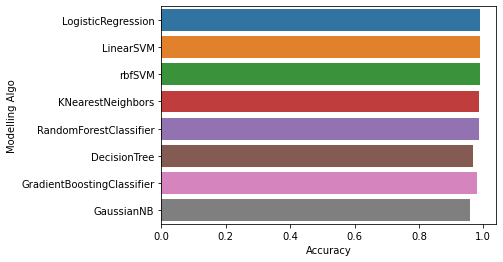

In [106]:
sns.barplot(y='Modelling Algo',x='Accuracy',data=acc);

## Tuning SVM with grid search cross validation

In [107]:
params_dict={'C':[0.001,0.01,0.1,1,10,100],'gamma':[0.001,0.01,0.1,1,10,100],'kernel':['linear','rbf']}
clf=GridSearchCV(estimator=SVC(),param_grid=params_dict,scoring='accuracy',cv=10)
clf.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

### show best parameter values to train on

In [108]:
clf.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [109]:
# best score
clf.best_score_

0.9828730620155038

In [119]:
# train on these paramaters
clf_svm=SVC(C=100,gamma=0.01,kernel='rbf')
clf_svm.fit(x_train,y_train)
pred=clf_svm.predict(x_test)
print(accuracy_score(pred,y_test))

0.9906832298136646


In [120]:
print(accuracy_score(clf_svm.predict(x_test),y_test))

0.9906832298136646


In [116]:
print(precision_score(clf_svm.predict(x_test),y_test))

0.9837837837837838


## There's not a remarkable difference between the original and tuned model, but it's a good practice.

## to me this notebook is about visuals more than modelling, but I had fun doing it with classic ML and it gave good results without the need for ANNs.